# Investigating vaginal microflora by cohort

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(data.table)
require(foreach)



Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when




### Load  data

In [22]:
meta <-fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") 
read_df <- fread("results/decontamination/read_matrix_n157.global_decontaminated.zeroed.csv")
RA_df <- fread("results/decontamination/RA_matrix_n157.global_decontaminated.zeroed.csv")
meta_filt <- meta %>% select(npm_research_id, site_supplying_sample, sequence_based_gender)
prev_df <- fread("results/decontamination/prevalence_RA0.005_read10.csv") %>%
  left_join(meta_filt)

df <- fread("results/irep_analysis/coverage_irep_results.raw.csv") %>%
  filter(!grepl("virus", prefix)) %>%
  left_join(meta) %>%
  filter(site_supplying_sample == "GUSTO") %>%
  select(npm_research_id, site_supplying_sample, sequence_based_gender, genus, species, perc_covered1, perc_covered5, bPTR)


head(df)

Joining, by = "npm_research_id"
Joining, by = "npm_research_id"


npm_research_id,site_supplying_sample,sequence_based_gender,genus,species,perc_covered1,perc_covered5,bPTR
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
WHB4035,GUSTO,F,Fannyhessea,vaginae,75.924947,9.31309968,1.876599
WHB4594,GUSTO,M,Fusobacterium,nucleatum,65.779293,57.50632591,1.675886
WHB4594,GUSTO,M,Fusobacterium,pseudoperiodonticum,39.381591,26.19540518,NA
WHB4450,GUSTO,M,Lactobacillus,crispatus,9.537874,0.04646424,NA
WHB4219,GUSTO,M,Staphylococcus,epidermidis,8.683066,0.01670382,NA
WHB3907,GUSTO,F,Prevotella,melaninogenica,6.400049,0.02638599,NA


In [23]:
prev_df %>% 
  group_by(site_supplying_sample) %>%
  summarise(F.vaginae = sum(`Fannyhessea vaginae`),
            F.nucleatum = sum(`Fusobacterium nucleatum`),
            F.pseudoperidonticum = sum(`Fusobacterium pseudoperiodonticum`),
            L.crispatus = sum(`Lactobacillus crispatus`),
            G.vaginalis = sum(`Gardnerella vaginalis`),
            L.iners = sum(`Lactobacillus iners`),
            L.jensenii = sum(`Lactobacillus jensenii`),
            n_samples = n())

site_supplying_sample,F.vaginae,F.nucleatum,F.pseudoperidonticum,L.crispatus,G.vaginalis,L.iners,L.jensenii,n_samples
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GUSTO,20,5,2,87,72,105,16,967
HELIOS,0,1,1,4,1,1,1,2285
MEC,1,2,1,3,2,0,0,2738
PRISM,0,0,0,0,0,0,0,1248
SERI,0,0,0,0,0,0,0,923
SSMP,0,0,0,0,0,0,0,4
TTSH,0,2,0,0,0,0,0,663


`summarise()` has grouped output by 'site_supplying_sample'. You can override using the `.groups` argument.


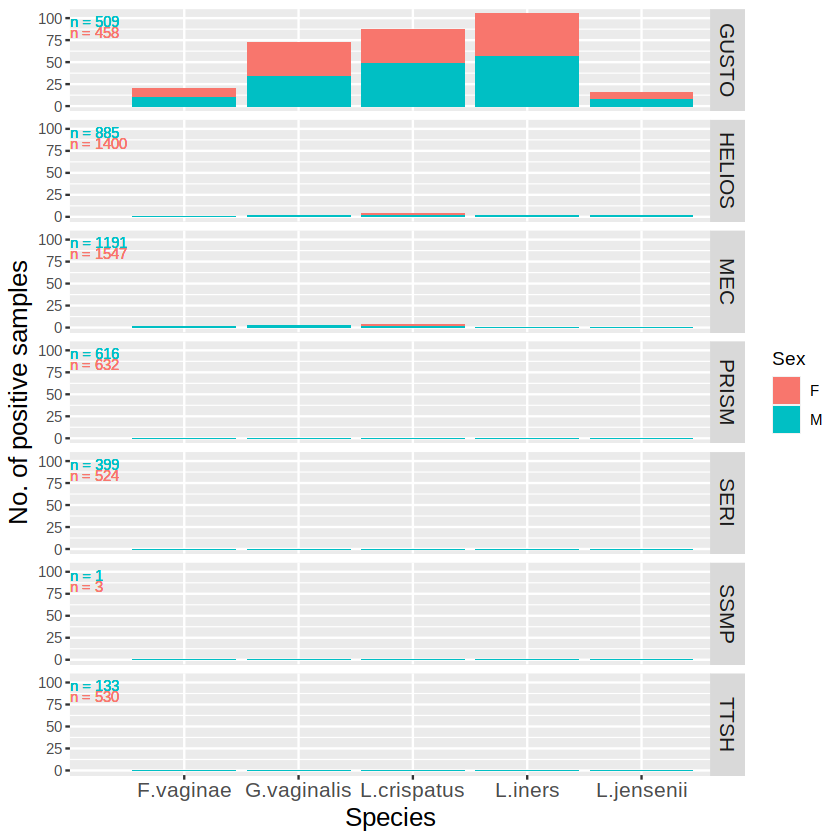

In [36]:
prev_df %>% 
  group_by(site_supplying_sample, sequence_based_gender) %>%
  summarise(F.vaginae = sum(`Fannyhessea vaginae`),
            L.crispatus = sum(`Lactobacillus crispatus`),
            G.vaginalis = sum(`Gardnerella vaginalis`),
            L.iners = sum(`Lactobacillus iners`),
            L.jensenii = sum(`Lactobacillus jensenii`),
            n_samples = n()) %>%
  pivot_longer(!c("site_supplying_sample", "n_samples", "sequence_based_gender"), names_to = "taxa", values_to = "count") %>%
  ggplot(aes(x = taxa, y = count, fill = sequence_based_gender)) +
    facet_grid(rows = vars(site_supplying_sample)) +
    geom_bar(stat = "identity") +
    geom_text(aes(x = 0, y = 90, 
                  label = str_glue("n = {n_samples}"),
                  color = sequence_based_gender,
                  vjust = ifelse(sequence_based_gender == "F", 1, 0)), 
              hjust = 0,
              size = 3) +
    scale_color_discrete(guide = "none") +
     labs(x = "Species", y = "No. of positive samples", fill = "Sex") +
    theme(axis.text.x = element_text(size = 12),
          axis.title.x = element_text(size = 15),
          axis.title.y = element_text(size = 15),
          strip.text = element_text(size = 12)) 

ggsave("results/experimental_validation/GUSTO_vaginal_microflora.gender.png", 
       width = 7, height = 6)

In [37]:
prev_df %>% 
  group_by(t2d, sequence_based_gender) %>%
  summarise(F.vaginae = sum(`Fannyhessea vaginae`),
            L.crispatus = sum(`Lactobacillus crispatus`),
            G.vaginalis = sum(`Gardnerella vaginalis`),
            L.iners = sum(`Lactobacillus iners`),
            L.jensenii = sum(`Lactobacillus jensenii`),
            n_samples = n()) %>%
  pivot_longer(!c("site_supplying_sample", "n_samples", "sequence_based_gender"), names_to = "taxa", values_to = "count") %>%
  ggplot(aes(x = taxa, y = count, fill = sequence_based_gender)) +
    facet_grid(rows = vars(site_supplying_sample)) +
    geom_bar(stat = "identity") +
    geom_text(aes(x = 0, y = 90, 
                  label = str_glue("n = {n_samples}"),
                  color = sequence_based_gender,
                  vjust = ifelse(sequence_based_gender == "F", 1, 0)), 
              hjust = 0,
              size = 3) +
    scale_color_discrete(guide = "none") +
     labs(x = "Species", y = "No. of positive samples", fill = "Sex") +
    theme(axis.text.x = element_text(size = 12),
          axis.title.x = element_text(size = 15),
          axis.title.y = element_text(size = 15),
          strip.text = element_text(size = 12)) 

# ggsave("results/experimental_validation/GUSTO_vaginal_microflora.gender.png", 
#        width = 7, height = 6)

ERROR: [1m[33mError[39m in [1m[1m[30m[47m`group_by_prepare()`[49m[39m:[22m
[33m![39m Must group by variables found in `.data`.
[36m•[39m Column `t2d` is not found.
